# NRPy+'s Reference Metric Interface

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

### NRPy+ Source Code for this module: [reference_metric.py](../edit/reference_metric.py)

## Introduction:
### Why use a reference metric? Benefits of choosing the best coordinate system for the problem

When solving a partial differential equation on the computer, it is useful to first pick a coordinate system well-suited to the geometry of the problem. For example, if we are modeling a spherically-symmetric star, it would be hugely wasteful to model the star in 3-dimensional Cartesian coordinates ($x$,$y$,$z$). This is because in Cartesian coordinates, we would need to choose high sampling in all three Cartesian directions. If instead we chose to model the star in spherical coordinates  ($r$,$\theta$,$\phi$), so long as the star is centered at $r=0$, we would not need to model the star with more than one point in the $\theta$ and $\phi$ directions!

A similar argument holds for stars that are *nearly* spherically symmetric. Such stars may exhibit density distributions that vary slowly in $\theta$ and $\phi$ directions (e.g., isolated neutron stars or black holes). In these cases the number of points needed to sample the angular directions will still be much smaller than in the radial direction.

Thus choice of an appropriate reference metric may directly mitigate the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follow

1. [Step 1](#define_ref_metric): Defining a reference metric, `reference\_metric.py`
1. [Step 2](#define_geometric): Defining geometric quantities, **`ref_metric__hatted_quantities()`**
1. [Step 3](#prescribed_ref_metric): Prescribed reference metrics in `reference_metric.py`
    1. [Step 3.a](#sphericallike): Spherical-like coordinate systems
    1. [Step 3.b](#cylindricallike): Cylindrical-like coordinate systems
    1. [Step 3.c](#cartesianlike): Cartesian-like coordinate systems
    1. [Step 3.d](#prolatespheroidal): Prolate spheroidal coordinates
1. [Step 4](#latex_pdf_output): Output this module to $\LaTeX$-formatted PDF file

<a id='define_ref_metric'></a>

# Step 1: Defining a reference metric, `reference_metric.py` \[Back to [top](#toc)\]
$$\label{define_ref_metric}$$

***Note that currently only orthogonal reference metrics of dimension 3 or fewer are supported. This can be extended if desired.***

NRPy+ assumes all curvilinear coordinate systems map directly from a uniform, Cartesian numerical grid with coordinates $(x,y,z)$=(`xx[0]`,`xx[1]`,`xx[2]`). Thus when defining reference metrics, all defined coordinate quantities must be in terms of the `xx[]` array. As we will see, this adds a great deal of flexibility

For example,  [**reference_metric.py**](../edit/reference_metric.py) requires that the *orthogonal coordinate scale factors* be defined. As described [here](https://en.wikipedia.org/wiki/Curvilinear_coordinates), the $i$th scale factor is the positive root of the metric element $g_{ii}$. In ordinary spherical coordinates $(r,\theta,\phi)$, with line element $ds^2 = g_{ij} dx^i dx^j = dr^2+ r^2 d \theta^2 + r^2 \sin^2\theta \ d\phi^2$, we would first define
* $r = xx_0$
* $\theta = xx_1$
* $\phi = xx_2$,

so that the scale factors are defined as
* `scalefactor_orthog[0]` = $1$
* `scalefactor_orthog[1]` = $r$
* `scalefactor_orthog[2]` = $r \sin \theta$

Here is the corresponding code:

In [1]:
import sympy as sp
import NRPy_param_funcs as par
import reference_metric as rfm

r = rfm.xx[0]
th = rfm.xx[1]
ph = rfm.xx[2]

rfm.scalefactor_orthog[0] = 1
rfm.scalefactor_orthog[1] = r
rfm.scalefactor_orthog[2] = r*sp.sin(th)

# Notice that the scale factor will be given 
#    in terms of the fundamental Cartesian
#    grid variables, and not {r,th,ph}:
print("r*sin(th) = "+str(rfm.scalefactor_orthog[2]))

r*sin(th) = xx0*sin(xx1)


Next suppose we wish to modify our radial coordinate $r(xx_0)$ to be an exponentially increasing function, so that our numerical grid $(xx_0,xx_1,xx_2)$ will map to a spherical grid with radial grid spacing ($\Delta r$) that *increases* with $r$. Generally we will find it useful to define $r(xx_0)$ to be an odd function, so let's choose

$$r(xx_0) = a \sinh(xx_0/s),$$

where $a$ is an overall radial scaling factor, and $s$ denotes the scale (in units of $xx_0$) over which exponential growth will take place. In our implementation below, note that we use the relation

$$\sinh(x) = \frac{e^x - e^{-x}}{2},$$

as SymPy finds it easier to evaluate exponentials than hyperbolic trigonometric functions.

In [2]:
a,s = sp.symbols('a s',positive=True)
xx0_rescaled = rfm.xx[0] / s
r = a*(sp.exp(xx0_rescaled) - sp.exp(-xx0_rescaled))/2

# Must redefine the scalefactors since 'r' has been updated!
rfm.scalefactor_orthog[0] = 1
rfm.scalefactor_orthog[1] = r
rfm.scalefactor_orthog[2] = r*sp.sin(th)

print(rfm.scalefactor_orthog[2])

a*(exp(xx0/s) - exp(-xx0/s))*sin(xx1)/2


Often we will find it useful to also define the appropriate mappings from (`xx[0]`,`xx[1]`,`xx[2]`) to Cartesian coordinates (for plotting purposes) and ordinary spherical coordinates (e.g., in case initial data when solving a PDE are naturally written in spherical coordinates). For this purpose, reference_metric.py also declares lists **`xxCart[]`** and **`xxSph[]`**, which in this case are defined as

In [3]:
rfm.xxSph[0] = r
rfm.xxSph[1] = th
rfm.xxSph[2] = ph

rfm.xxCart[0] = r*sp.sin(th)*sp.cos(ph)
rfm.xxCart[1] = r*sp.sin(th)*sp.sin(ph)
rfm.xxCart[2] = r*sp.cos(th)

# Here we show off SymPy's pretty_print() 
#   and simplify() functions. Nice, no?
sp.pretty_print(sp.simplify(rfm.xxCart[0]))

                        ⎛xx₀⎞
a⋅sin(xx₁)⋅cos(xx₂)⋅sinh⎜───⎟
                        ⎝ s ⎠


<a id='define_geometric'></a>

# Step 2: Define geometric quantities, `ref_metric__hatted_quantities()` \[Back to [top](#toc)\]
$$\label{define_geometric}$$

Once `scalefactor_orthog[]` has been defined, the function **`ref_metric__hatted_quantities()`** within [reference_metric.py](../edit/reference_metric.py) can be called to define a number of geometric quantities useful for solving PDEs in curvilinear coordinate systems. 

Adopting the notation of [Baumgarte, Montero, Cordero-Carrión, and Müller, PRD 87, 044026 (2012)](https://arxiv.org/abs/1211.6632), geometric quantities related to the reference metric are named "hatted" quantities, . For example, the reference metric is defined as $\hat{g}_{ij}$=`ghatDD[i][j]`:

In [4]:
rfm.ref_metric__hatted_quantities()

sp.pretty_print(sp.Matrix(sp.simplify(rfm.ghatDD)))

⎡1           0                         0              ⎤
⎢                                                     ⎥
⎢                     2                               ⎥
⎢      ⎛ xx₀    -xx₀ ⎞                                ⎥
⎢      ⎜ ───    ─────⎟                                ⎥
⎢    2 ⎜  s       s  ⎟                                ⎥
⎢   a ⋅⎝ℯ    - ℯ     ⎠                                ⎥
⎢0  ───────────────────                0              ⎥
⎢            4                                        ⎥
⎢                                                     ⎥
⎢                                          2          ⎥
⎢                           ⎛ xx₀    -xx₀ ⎞           ⎥
⎢                           ⎜ ───    ─────⎟           ⎥
⎢                         2 ⎜  s       s  ⎟     2     ⎥
⎢                        a ⋅⎝ℯ    - ℯ     ⎠ ⋅sin (xx₁)⎥
⎢0           0           ─────────────────────────────⎥
⎣                                      4              ⎦


In addition to $\hat{g}_{ij}$, **`ref_metric__hatted_quantities()`** also provides:
* The rescaling "matrix" `ReDD[i][j]`, used for separating singular (due to chosen coordinate system) pieces of smooth rank-2 tensor components from the smooth parts, so that the smooth parts can be used within temporal and spatial differential operators.
* Inverse reference metric: $\hat{g}^{ij}$=`ghatUU[i][j]`.
* Reference metric determinant: $\det\left(\hat{g}_{ij}\right)$=`detgammahat`.
* First and second derivatives of the reference metric: $\hat{g}_{ij,k}$=`ghatDD_dD[i][j][k]`; $\hat{g}_{ij,kl}$=`ghatDD_dDD[i][j][k][l]`
* Christoffel symbols associated with the reference metric, $\hat{\Gamma}^i_{jk}$ = `GammahatUDD[i][j][k]` and their first derivatives $\hat{\Gamma}^i_{jk,l}$ = `GammahatUDD_dD[i][j][k][l]`

For example, the Christoffel symbol $\hat{\Gamma}^{xx_1}_{xx_2 xx_2}=\hat{\Gamma}^1_{22}$ is given by `GammahatUDD[1][2][2]`:

In [5]:
sp.pretty_print(sp.simplify(rfm.GammahatUDD[1][2][2]))

-sin(2⋅xx₁) 
────────────
     2      


Given the trigonometric identity $2\sin(x)\cos(x) = \sin(2x)$, notice that the above expression is equivalent to Eq. 18 of [Baumgarte, Montero, Cordero-Carrión, and Müller, PRD 87, 044026 (2012)](https://arxiv.org/abs/1211.6632). This is expected since the sinh-radial spherical coordinate system is equivalent to ordinary spherical coordinates in the angular components.

<a id='prescribed_ref_metric'></a>

# Step 3: Prescribed reference metrics in `reference_metric.py` \[Back to [top](#toc)\]
$$\label{prescribed_ref_metric}$$

One need not manually define scale factors or other quantities for reference metrics, as a number of prescribed reference metrics are already defined in [reference_metric.py](../edit/reference_metric.py). These can be accessed by first setting the parameter **reference_metric::CoordSystem** to one of the following, and then calling the function **`rfm.reference_metric()`**:

<a id='sphericallike'></a>

## Step 3.a: Spherical-like coordinate systems \[Back to [top](#toc)\]
$$\label{sphericallike}$$

* **reference_metric::CoordSystem = "Spherical"**: Standard spherical coordinates, with $(r,\theta,\phi)=(xx_0,xx_1,xx_2)$
* **reference_metric::CoordSystem = "SinhSpherical"**: Spherical coordinates, but with $$r(xx_0) = \text{AMPL} \frac{\sinh\left(\frac{xx_0}{\text{SINHW}}\right)}{\sinh\left(\frac{1}{\text{SINHW}}\right)}$$
* **reference_metric::CoordSystem = "SinhSphericalv2"**: Spherical coordinates, but with 
    $$r(xx_0) = \text{AMPL} \left[\text{const_dr}\ xx_0 + \frac{\sinh\left(\frac{xx_0}{\text{SINHW}}\right)}{\sinh\left(\frac{1}{\text{SINHW}}\right)}\right]$$
    
Next let's plot **SinhSpherical** coordinates with `SINHW=0.4` and `AMPL=1.0`.

<Figure size 432x288 with 0 Axes>

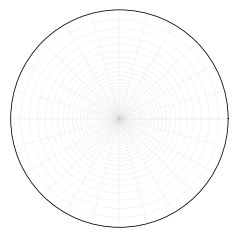

In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.clf()

r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r * 0
fig = plt.figure()

ax = plt.subplot(111, projection='polar')


# Plot individual points:
#ax.plot(0.5,1.0,color="green",marker='s')

#ax.plot(theta, r)
ax.set_rmax(2)
# ax.set_rticks([0.1, 0.3, 1.0, 2])  # less radial ticks
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line

Nr = 50
xx0s = np.linspace(0,2,Nr, endpoint=True) + 1.0/(2.0*Nr)
# print(xx0s)

rs = []
# print(const_dr)
AMPL = 1.0
const_dr = 0.1
const_dr = 1.0/(xx0s[len(xx0s)-1] * AMPL)
SINHW = 0.4
for i in range(Nr):
    rs.append(AMPL * (const_dr*xx0s[i] + (np.exp(xx0s[i] / SINHW) - np.exp(-xx0s[i] / SINHW)) / \
                        (np.exp(1.0 / SINHW) - np.exp(-1.0 / SINHW)) ) )

ax.set_rgrids(rs,labels=[])

thetas = np.linspace(0,360,25, endpoint=True)
# print(thetas)
ax.set_thetagrids(thetas,labels=[])

# ax.grid(True)
ax.grid(True,linewidth='0.1')

# ax.set_title("A line plot on a polar axis", va='bottom')
# plt.savefig("sphgrid.png",dpi=1000)
plt.show()
# plt.close(fig)

<a id='cylindricallike'></a>

## Step 3.b: Cylindrical-like coordinate systems \[Back to [top](#toc)\]
$$\label{cylindricallike}$$

* **reference_metric::CoordSystem = "Cylindrical"**: Standard cylindrical coordinates, with $(\rho,\phi,z)=(xx_0,xx_1,xx_2)$
    * **reference_metric::CoordSystem = "SinhCylindrical"**: Cylindrical coordinates, but with
    $$\rho(xx_0) = \text{AMPLRHO} \frac{\sinh\left(\frac{xx_0}{\text{SINHWRHO}}\right)}{\sinh\left(\frac{1}{\text{SINHWRHO}}\right)}$$
    and 
    $$z(xx_2) = \text{AMPLZ} \frac{\sinh\left(\frac{xx_2}{\text{SINHWZ}}\right)}{\sinh\left(\frac{1}{\text{SINHWZ}}\right)}$$
    
* **reference_metric::CoordSystem = "SinhCylindricalv2"**: Cylindrical coordinates, but with
$$\rho(xx_0) = \text{AMPLRHO} \left[\text{const_drho}\ xx_0 + \frac{\sinh\left(\frac{xx_0}{\text{SINHWRHO}}\right)}{\sinh\left(\frac{1}{\text{SINHWRHO}}\right)}\right]$$
and 
$$z(xx_2) = \text{AMPLZ} \left[\text{const_dz}\ xx_2 + \frac{\sinh\left(\frac{xx_2}{\text{SINHWZ}}\right)}{\sinh\left(\frac{1}{\text{SINHWZ}}\right)}\right]$$


For example, let's set up SinhCylindricalv2 coordinates and output the Christoffel symbol $\hat{\Gamma}^{xx_2}_{xx_2 xx_2}$, or more simply $\hat{\Gamma}^2_{22}$:

In [7]:
par.set_parval_from_str("reference_metric::CoordSystem","SinhCylindricalv2")

rfm.reference_metric()

sp.pretty_print(sp.simplify(rfm.GammahatUDD[2][2][2]))

                         ⎛ 2⋅xx₂     ⎞    1                             
                         ⎜ ──────    ⎟  ──────                          
                         ⎜ SINHWZ    ⎟  SINHWZ                          
                        -⎝ℯ       - 1⎠⋅ℯ                                
────────────────────────────────────────────────────────────────────────
       ⎛                  ⎛   2       ⎞   xx₂     ⎛ 2⋅xx₂     ⎞    1   ⎞
       ⎜                  ⎜ ──────    ⎟  ──────   ⎜ ──────    ⎟  ──────⎟
       ⎜                  ⎜ SINHWZ    ⎟  SINHWZ   ⎜ SINHWZ    ⎟  SINHWZ⎟
SINHWZ⋅⎝- SINHWZ⋅const_dz⋅⎝ℯ       - 1⎠⋅ℯ       - ⎝ℯ       + 1⎠⋅ℯ      ⎠


As we will soon see, defining these "hatted" quantities will be quite useful when expressing hyperbolic ([wave-equation](https://en.wikipedia.org/wiki/Wave_equation)-like) PDEs in non-Cartesian coordinate systems.

<a id='cartesianlike'></a>

## Step 3.c: Cartesian coordinate systems \[Back to [top](#toc)\]
$$\label{cartesianlike}$$

* **reference_metric::CoordSystem = "Cartesian"**: Standard Cartesian coordinates, with $(x,y,z)=(xx_0,xx_1,xx_2)$

<a id='prolatespheroidal'></a>

## Step 3.d: [Prolate spheroidal](https://en.wikipedia.org/wiki/Prolate_spheroidal_coordinates)-like coordinate systems \[Back to [top](#toc)\]
$$\label{prolatespheroidal}$$
    
* **reference_metric::CoordSystem = "SymTP"**: Symmetric TwoPuncture coordinates, with $(\rho,\phi,z)=(xx_0\sin(xx_1), xx_2, \sqrt{xx_0^2 + \text{bScale}^2}\cos(xx_1))$
* **reference_metric::CoordSystem = "SinhSymTP"**: Symmetric TwoPuncture coordinates, but with $$xx_0 \to \sinh(xx_0/\text{AW})$$

<a id='latex_pdf_output'></a>

# Step 4: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Reference_Metric.pdf](Tutorial-Reference_Metric.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [8]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx Tutorial-Reference_Metric.ipynb
!pdflatex -interaction=batchmode Tutorial-Reference_Metric.tex
!pdflatex -interaction=batchmode Tutorial-Reference_Metric.tex
!pdflatex -interaction=batchmode Tutorial-Reference_Metric.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-Reference_Metric.ipynb to latex
[NbConvertApp] Support files will be in Tutorial-Reference_Metric_files/
[NbConvertApp] Making directory Tutorial-Reference_Metric_files
[NbConvertApp] Writing 46889 bytes to Tutorial-Reference_Metric.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
